In [1]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AddChanneld,
    AsChannelFirstd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    EnsureChannelFirstd,
    EnsureTyped,
    EnsureType,
    Invertd,
    Lambdad,
    LoadImaged,
    RandFlipd,
    RandSpatialCropd,
    RandZoomd,
    Resized,
    ScaleIntensityRanged,
    SpatialCrop,
    SpatialCropd,
    ToTensord,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import monai.utils as utils

import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
from glob import glob

import itk
from itk import TubeTK as ttk

import numpy as np

import site
import ubelt as ub
import pint
site.addsitedir('../../../ARGUS')
from ARGUS_Transforms import ARGUS_RandSpatialCropSlicesd  #NOQA
Ureg = pint.UnitRegistry()

In [2]:
img1_dir = "../../Data_PNB/annotations_yuri/"
img2_dir = "../../Data_PNB/annotations_yuri/CLEANED/"
    
all_images = sorted(glob(os.path.join(img1_dir, '*_cropM.nii.gz')))
all_labels = sorted(glob(os.path.join(img2_dir, '*.overlay.mha')))

num_devices = 1
gpu_device = 2
runs = 5

num_classes = 2

net_in_dims = 2 # Spatial Dimensions
net_in_channels = 3 # Mean, Std, RawFrame
net_channels=(16, 32, 64, 128, 32)
net_strides=(2, 2, 2, 2)
        
num_folds = 10

num_slice = 16
size_x = 320
size_y = 640

num_workers_te = 2
batch_size_te = 2

In [3]:
num_images = len(all_images)
print("Num images / labels =", num_images, len(all_labels))

p_prefix = [' 11',
            ' 67', 
            ' 93', 
            ' 94', 
            ' 134',
            ' 211', 
            ' 222A',  
            ' 153', 
            ' 240',  
            ' 193']
n_prefix = [' 57',
            ' 136', 
            ' 179', 
            ' 189', 
            ' 204', 
            ' 205', 
            ' 217', 
            ' 238',  
            ' 39',
            ' 191']

fold_prefix_list = []
p_count = 0
n_count = 0
for i in range(num_folds):
    if i%2 == 0:
        num_p = 1
        num_n = 1
        if i > num_folds-2:
            num_p = 2
    else:
        num_p = 1
        num_n = 1
    f = []
    if p_count < len(p_prefix):
        for p in range(num_p):
            f.append([p_prefix[p_count+p]])
    p_count += num_p
    if n_count < len(n_prefix):
        for n in range(num_n):
            f.append([n_prefix[n_count+n]])
    n_count += num_n
    fold_prefix_list.append(f)

for i in range(num_folds):
    print(i, fold_prefix_list[i])

Num images / labels = 25 25
0 [[' 11'], [' 57']]
1 [[' 67'], [' 136']]
2 [[' 93'], [' 179']]
3 [[' 94'], [' 189']]
4 [[' 134'], [' 204']]
5 [[' 211'], [' 205']]
6 [[' 222A'], [' 217']]
7 [[' 153'], [' 238']]
8 [[' 240'], [' 39']]
9 [[' 193'], [' 191']]


In [4]:
total_bytes = 0
for p in all_images:
    p = ub.Path(p)
    total_bytes += p.stat().st_size
print((total_bytes * Ureg.byte).to('GiB'))

total_bytes = 0
for p in all_labels:
    p = ub.Path(p)
    total_bytes += p.stat().st_size
print((total_bytes * Ureg.byte).to('GiB'))

2.4898208379745483 gibibyte
0.012151464819908142 gibibyte


In [5]:
train_files = []
val_files = []
test_files = []
for i in range(num_folds):
    tr_folds = []
    va_folds = []
    for f in range(i,i+num_folds-3):
        tr_folds.append(fold_prefix_list[f%num_folds])
    tr_folds = list(np.concatenate(tr_folds).flat)
    for f in range(i+num_folds-3, i+num_folds-1):
        va_folds.append(fold_prefix_list[f%num_folds])
    va_folds = list(np.concatenate(va_folds).flat)
    te_folds = list(np.concatenate(fold_prefix_list[(i+num_folds-1) % num_folds]).flat)
    train_files.append(
            [
                {"image": img, "label": seg}
                for img, seg in zip(
                    [im for im in all_images if any(pref in im for pref in tr_folds)],
                    [se for se in all_labels if any(pref in se for pref in tr_folds)])
            ]
        )
    val_files.append(
            [
                {"image": img, "label": seg}
                for img, seg in zip(
                    [im for im in all_images if any(pref in im for pref in va_folds)],
                    [se for se in all_labels if any(pref in se for pref in va_folds)])
            ]
        )
    test_files.append(
            [
                {"image": img, "label": seg}
                for img, seg in zip(
                    [im for im in all_images if any(pref in im for pref in te_folds)],
                    [se for se in all_labels if any(pref in se for pref in te_folds)])
            ]
        )
    print(len(train_files[i]),len(val_files[i]),len(test_files[i]))

18 5 2
19 4 2
19 4 2
19 4 2
18 4 3
17 5 3
16 6 3
16 6 3
16 6 3
17 6 2


In [6]:
test_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AsChannelFirstd(keys='image'),
        AsChannelFirstd(keys='label'),
        ScaleIntensityRanged(
            a_min=0, a_max=255,
            b_min=0.0, b_max=1.0,
            keys=["image"]),
        ARGUS_RandSpatialCropSlicesd(
            num_slices=[num_slice,1],
            center_slice=-num_slice/2 - 1,
            axis=0,
            reduce_to_statistics=[True,False],
            extended=False,
            include_center_slice=True,
            include_mean_abs_diff=False,
            keys=['image','label']),
        Resized(
            spatial_size=(-1,640),
            mode=["bilinear","nearest"],
            keys=['image','label']
        ),
        ToTensord(keys=["image", "label"]),
    ]
)

In [7]:
device = torch.device("cpu")

In [10]:
model_type = "best"  #"best" or "last"

def plot_vfold_training_curves(vfold_num, test_loader):
    print("VFOLD =", vfold_num, "of", num_folds - 1)
    ensemble_test_data = []
    for run in range(0,runs):
        model_filename_base = "./results/BAMC_PNB-CLEANED_ARUNet-3D-Mean_StdDevOverTime_RawFrame-yuriArteryData-" + str(num_slice) + "s-VFold-Run" + str(run)
        model_filename_base = model_filename_base + "/"
        model_file = model_filename_base+model_type + '_model.vfold_' + str(vfold_num) + '.pth'
        if os.path.exists(model_file):
            model = UNet(
                dimensions=net_in_dims,
                in_channels=net_in_channels,
                out_channels=num_classes,
                channels=net_channels,
                strides=net_strides,
                num_res_units=2,
                norm=Norm.BATCH,
        ).to(device)
            dice_metric = DiceMetric(include_background=False, reduction="mean")
            post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=True, num_classes=num_classes)])
            post_label = Compose([EnsureType(), AsDiscrete(to_onehot=True, num_classes=num_classes)])   
            model.load_state_dict(torch.load(model_file))
            model.eval()

            with torch.no_grad():
                i = 0
                for b,test_data in enumerate(test_loader):
                    print(b)
                    print(test_data["image"].shape)
                    roi_size = (size_x, size_y)
                    sw_batch_size = 1
                    test_outputs = sliding_window_inference(
                        test_data["image"].to(device), roi_size, sw_batch_size, model
                    )
                    test_labels = test_data["label"].to(device)
                    test_outputs_list = [post_pred(i) for i in decollate_batch(test_outputs)]
                    test_labels_list = [post_label(i) for i in decollate_batch(test_labels)]
                    dice_metric(y_pred=test_outputs_list, y=test_labels_list)
                    metric = dice_metric.aggregate().item()
                    print("Average test dice score for Vfold " + str(vfold_num) + " = " +str(metric))
                    dice_metric.reset()
                    if b > 0:
                        test_outputs_total = np.concatenate((test_outputs_total,test_outputs),axis=0)
                        test_images_total = np.concatenate((test_images_total,test_data["image"].to(device)),axis=0)
                        test_labels_total = np.concatenate((test_labels_total,test_data["label"].to(device)),axis=0)
                        i += 1
                    else:
                        test_outputs_total = test_outputs
                        test_images_total = test_data["image"].to(device)
                        test_labels_total = test_data["label"].to(device)
                ensemble_test_data.append(test_outputs_total)

    artery_prior = 1
    class_artery = 1

    min_size = 20000 #110000
    max_size = 30000 #160000
    
    for x in range(0,len(test_files[vfold_num])):
        print(test_files[vfold_num][x]["image"])
    for j in range(test_outputs_total.shape[0]):
        print("J = " + str(j))
        print("Filename: ")
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image")
        tmpV = test_images_total[j,0,:,:]
        plt.imshow(tmpV, cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label")
        tmpV = test_labels_total[j,0,:,:]
        tmpV[0,0]=0
        tmpV[0,1]=1
        plt.imshow(tmpV)
        plt.subplot(1, 3, 3)
        plt.title(f"output")
        prob_shape = test_outputs_total[j,:,:,:].shape
        prob = np.empty(prob_shape)
        class_array_total = 0
        for run in range(0,runs):
            test_op = ensemble_test_data[run]
            for c in range(num_classes):
                itkProb = itk.GetImageFromArray(test_op[j,c,:,:])
                imMathProb = ttk.ImageMath.New(itkProb)
                imMathProb.Blur(5)
                itkProb = imMathProb.GetOutput()
                prob[c] = itk.GetArrayFromImage(itkProb)
            class_array = np.zeros(prob[0].shape)
            pmin = prob[0].min()
            pmax = prob[0].max()
            for c in range(1,num_classes):
                pmin = min(pmin, prob[c].min())
                pmax = max(pmax, prob[c].max())
            prange = pmax - pmin
            prob = (prob - pmin) / prange
            prob[class_artery] = prob[class_artery] * artery_prior
            done = False
            while not done:
                done = True
                count = np.count_nonzero(class_array>0)
                while count<min_size:
                    prob[class_artery] = prob[class_artery] * 1.05
                    class_array = np.argmax(prob,axis=0)
                    count = np.count_nonzero(class_array>0)
                    done = False
                while count>max_size:
                    prob[class_artery] = prob[class_artery] * 0.95
                    class_array = np.argmax(prob,axis=0)
                    count = np.count_nonzero(class_array>0)
                    done = False
            class_array_total += class_array

        class_array_total = class_array_total // runs
        class_array = np.where(class_array_total==1,1,0)
        class_image = itk.GetImageFromArray(class_array.astype(np.float32))
        imMathClassCleanup = ttk.ImageMath.New(class_image)
        imMathClassCleanup.Erode(5,class_artery,0)
        imMathClassCleanup.Dilate(5,class_artery,0)
        class_output = imMathClassCleanup.GetOutputUChar()
        
        seg = itk.itkARGUS.SegmentConnectedComponents.New(Input=class_output)
        seg.SetKeepOnlyLargestComponent(True)
        seg.Update()

        class_output = seg.GetOutput()
        class_output_array = itk.GetArrayFromImage(class_output)
        test_label = test_labels_total[j,:,:,:]
        tmpV[0,0]=0
        tmpV[0,1]=1
        class_output_array[0,0]=0
        class_output_array[0,1]=1
        plt.imshow(class_output_array)
        plt.show()


Loading dataset: 100%|██████████| 2/2 [00:04<00:00,  2.31s/it]

VFOLD = 0 of 9



`to_onehot=True/False` is deprecated, please use `to_onehot=num_classes` instead.
Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


0
torch.Size([2, 3, 661, 640])
Average test dice score for Vfold 0 = 0.8558250665664673


Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


0
torch.Size([2, 3, 661, 640])
Average test dice score for Vfold 0 = 0.8157187700271606


Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


0
torch.Size([2, 3, 661, 640])
Average test dice score for Vfold 0 = 0.8060635328292847


Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


0
torch.Size([2, 3, 661, 640])
Average test dice score for Vfold 0 = 0.7268187999725342


Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


0
torch.Size([2, 3, 661, 640])
Average test dice score for Vfold 0 = 0.8250076770782471
total data length = 5
../../Data_PNB/annotations_yuri/5. 191 AC_Video 5_cropM.nii.gz
../../Data_PNB/annotations_yuri/7. 193 AC Video 4_cropM.nii.gz
J = 0
Filename: 


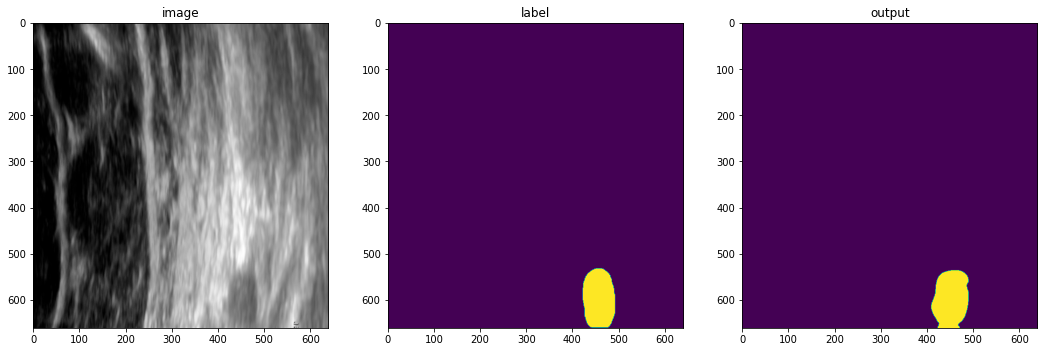

J = 1
Filename: 


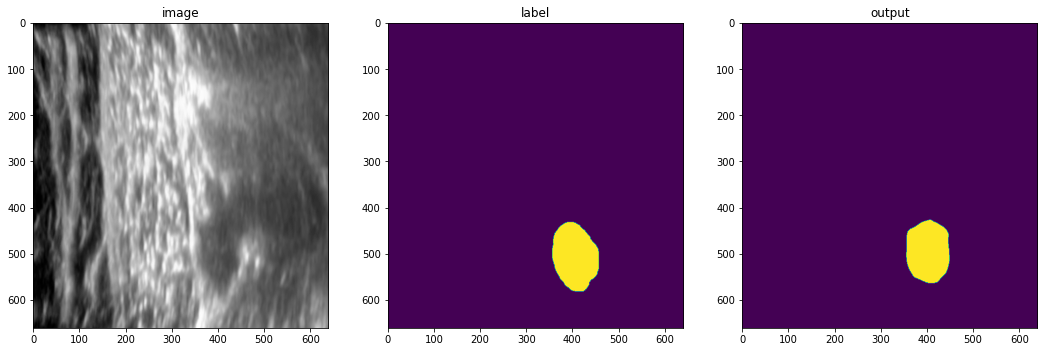

Loading dataset: 100%|██████████| 2/2 [00:04<00:00,  2.41s/it]

VFOLD = 1 of 9



Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


0
torch.Size([2, 3, 661, 640])
Average test dice score for Vfold 1 = 0.30953678488731384


Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


0
torch.Size([2, 3, 661, 640])
Average test dice score for Vfold 1 = 0.29120439291000366


Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


0
torch.Size([2, 3, 661, 640])
Average test dice score for Vfold 1 = 0.3202766478061676


Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


0
torch.Size([2, 3, 661, 640])
Average test dice score for Vfold 1 = 0.3004229962825775


Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


0
torch.Size([2, 3, 661, 640])
Average test dice score for Vfold 1 = 0.27327457070350647
total data length = 5
../../Data_PNB/annotations_yuri/1. 57 AC_Video 1_cropM.nii.gz
../../Data_PNB/annotations_yuri/3. 11 AC_Video 2_cropM.nii.gz
J = 0
Filename: 


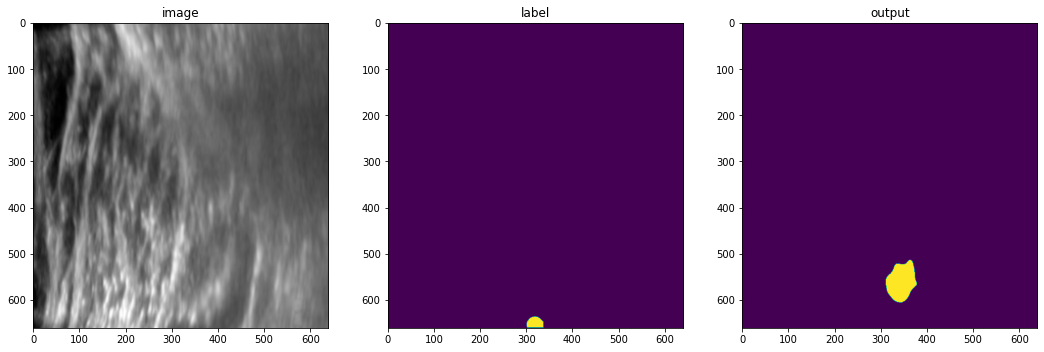

J = 1
Filename: 


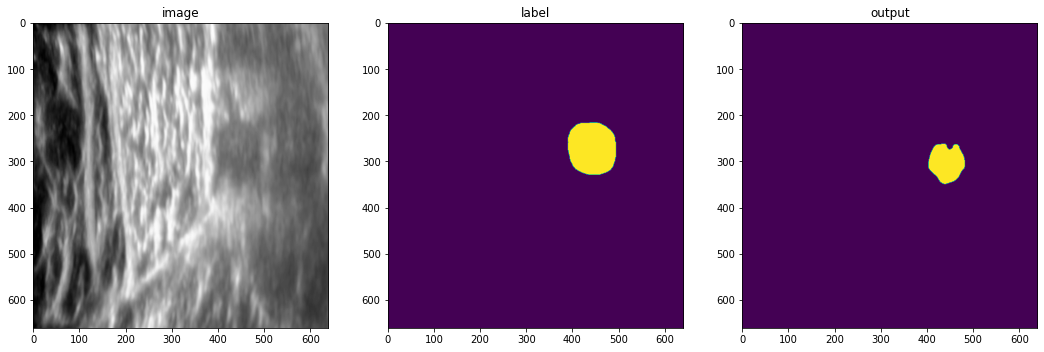

Loading dataset: 100%|██████████| 2/2 [00:06<00:00,  3.24s/it]

VFOLD = 2 of 9



Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


0
torch.Size([2, 3, 661, 640])
Average test dice score for Vfold 2 = 0.17692416906356812


Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


0
torch.Size([2, 3, 661, 640])
Average test dice score for Vfold 2 = 0.1636369228363037


Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


0
torch.Size([2, 3, 661, 640])
Average test dice score for Vfold 2 = 0.3101256489753723


Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


0
torch.Size([2, 3, 661, 640])
Average test dice score for Vfold 2 = 0.2190273404121399


Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


0
torch.Size([2, 3, 661, 640])
Average test dice score for Vfold 2 = 0.2316492199897766
total data length = 5
../../Data_PNB/annotations_yuri/1. 136 AC_Video 1_cropM.nii.gz
../../Data_PNB/annotations_yuri/3. 67 AC_Video 2_cropM.nii.gz
J = 0
Filename: 


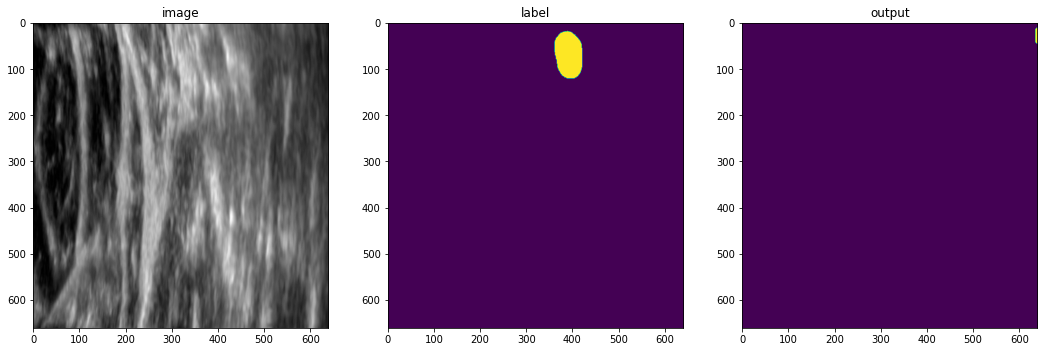

J = 1
Filename: 


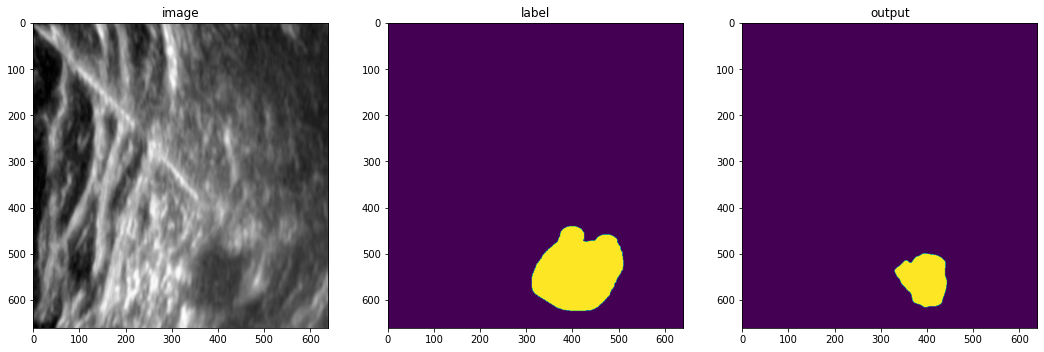

Loading dataset: 100%|██████████| 2/2 [00:05<00:00,  2.62s/it]

VFOLD = 3 of 9



Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


0
torch.Size([2, 3, 661, 640])
Average test dice score for Vfold 3 = 0.5262165069580078


Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


0
torch.Size([2, 3, 661, 640])
Average test dice score for Vfold 3 = 0.5696660280227661


Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


0
torch.Size([2, 3, 661, 640])
Average test dice score for Vfold 3 = 0.5082899928092957


Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


0
torch.Size([2, 3, 661, 640])
Average test dice score for Vfold 3 = 0.6055152416229248


Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


0
torch.Size([2, 3, 661, 640])
Average test dice score for Vfold 3 = 0.6381784677505493
total data length = 5
../../Data_PNB/annotations_yuri/1. 179 AC_Video 1_cropM.nii.gz
../../Data_PNB/annotations_yuri/3. 93 AC_Video 2_cropM.nii.gz
J = 0
Filename: 


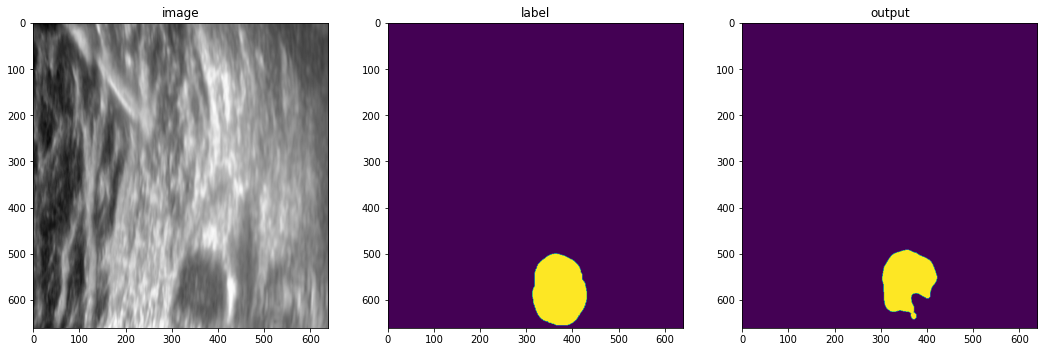

J = 1
Filename: 


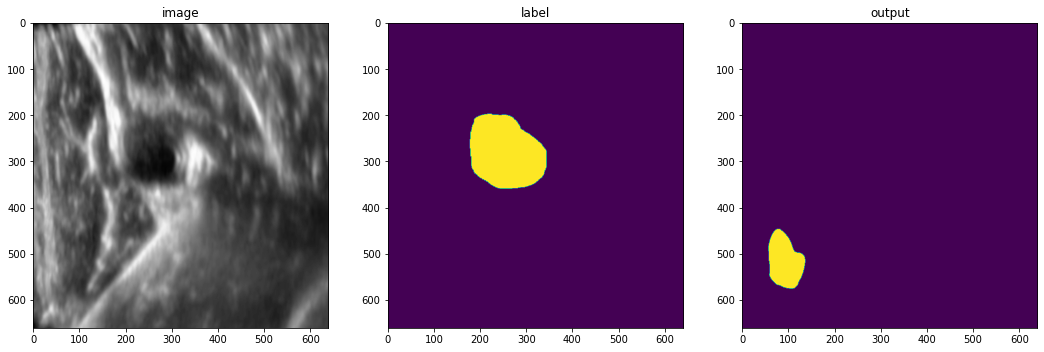

Loading dataset: 100%|██████████| 3/3 [00:06<00:00,  2.26s/it]

VFOLD = 4 of 9



Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


0
torch.Size([2, 3, 661, 640])
Average test dice score for Vfold 4 = 0.5134849548339844
1
torch.Size([1, 3, 661, 640])
Average test dice score for Vfold 4 = 0.6671046614646912


Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


0
torch.Size([2, 3, 661, 640])
Average test dice score for Vfold 4 = 0.43377453088760376
1
torch.Size([1, 3, 661, 640])
Average test dice score for Vfold 4 = 0.4958735704421997


Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


0
torch.Size([2, 3, 661, 640])
Average test dice score for Vfold 4 = 0.588058352470398
1
torch.Size([1, 3, 661, 640])
Average test dice score for Vfold 4 = 0.6980156302452087


Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


0
torch.Size([2, 3, 661, 640])
Average test dice score for Vfold 4 = 0.4254964590072632
1
torch.Size([1, 3, 661, 640])
Average test dice score for Vfold 4 = 0.5246800780296326


Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


0
torch.Size([2, 3, 661, 640])
Average test dice score for Vfold 4 = 0.5679024457931519
1
torch.Size([1, 3, 661, 640])
Average test dice score for Vfold 4 = 0.6397770643234253
total data length = 5
../../Data_PNB/annotations_yuri/1. 189 AC_Video 1_cropM.nii.gz
../../Data_PNB/annotations_yuri/3. 189 AC_Video 2_cropM.nii.gz
../../Data_PNB/annotations_yuri/3. 94 AC_Video 2_cropM.nii.gz
J = 0
Filename: 


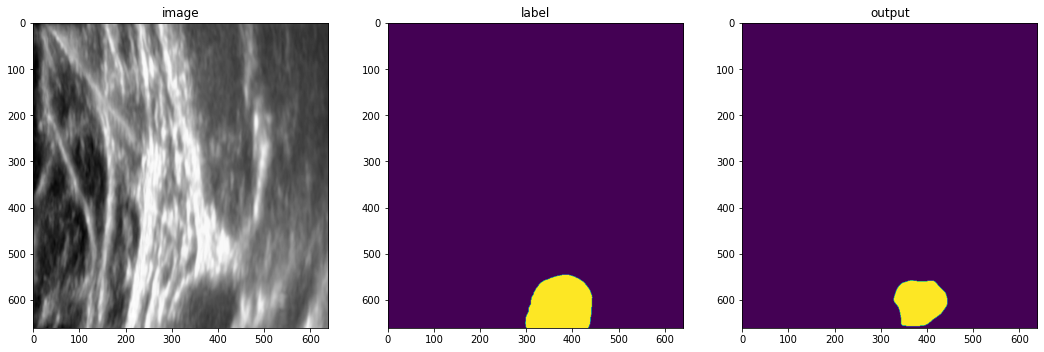

J = 1
Filename: 


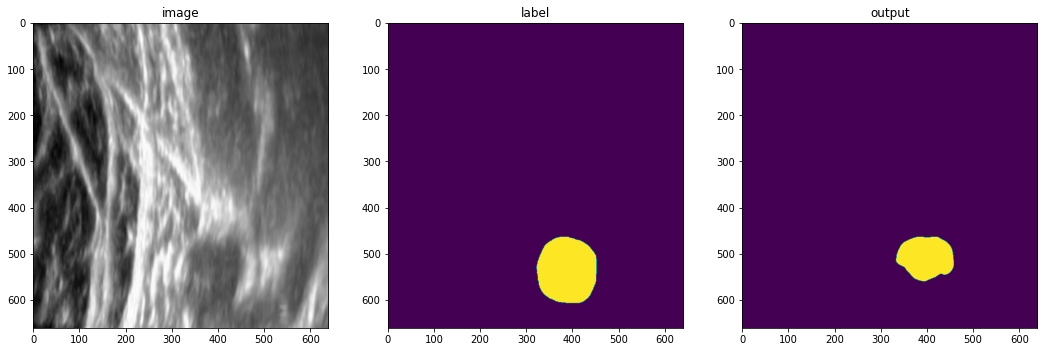

J = 2
Filename: 


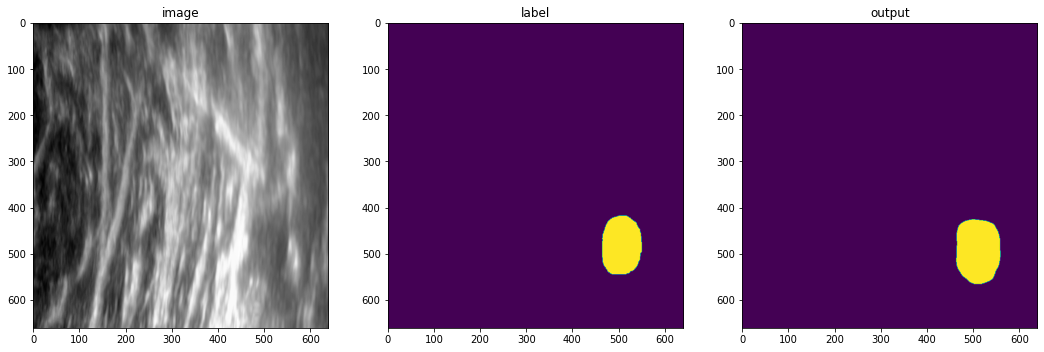

Loading dataset: 100%|██████████| 3/3 [00:09<00:00,  3.17s/it]

VFOLD = 5 of 9



Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


0
torch.Size([2, 3, 661, 640])
Average test dice score for Vfold 5 = 0.33114421367645264
1
torch.Size([1, 3, 661, 640])
Average test dice score for Vfold 5 = 0.004943357314914465


Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


0
torch.Size([2, 3, 661, 640])
Average test dice score for Vfold 5 = 0.4169948399066925
1
torch.Size([1, 3, 661, 640])
Average test dice score for Vfold 5 = 0.02491944096982479


Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


0
torch.Size([2, 3, 661, 640])
Average test dice score for Vfold 5 = 0.33339235186576843
1
torch.Size([1, 3, 661, 640])
Average test dice score for Vfold 5 = 0.0


Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


0
torch.Size([2, 3, 661, 640])
Average test dice score for Vfold 5 = 0.41043001413345337
1
torch.Size([1, 3, 661, 640])
Average test dice score for Vfold 5 = 0.0


Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


0
torch.Size([2, 3, 661, 640])
Average test dice score for Vfold 5 = 0.4324195683002472
1
torch.Size([1, 3, 661, 640])
Average test dice score for Vfold 5 = 0.0
total data length = 5
../../Data_PNB/annotations_yuri/1. 134 AC_Video 1_cropM.nii.gz
../../Data_PNB/annotations_yuri/1. 204 AC Video 1_cropM.nii.gz
../../Data_PNB/annotations_yuri/3. 134 AC_Video 2_cropM.nii.gz
J = 0
Filename: 


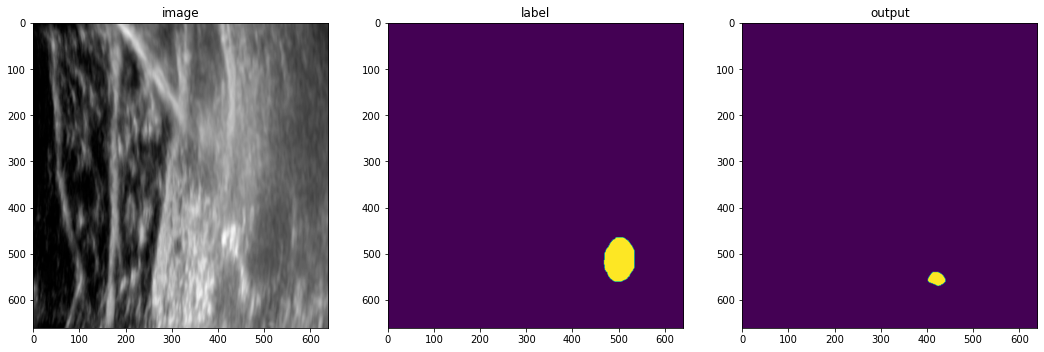

J = 1
Filename: 


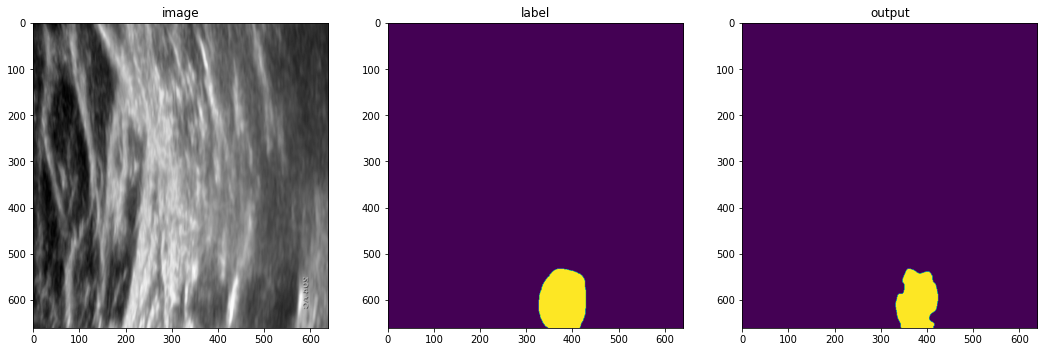

J = 2
Filename: 


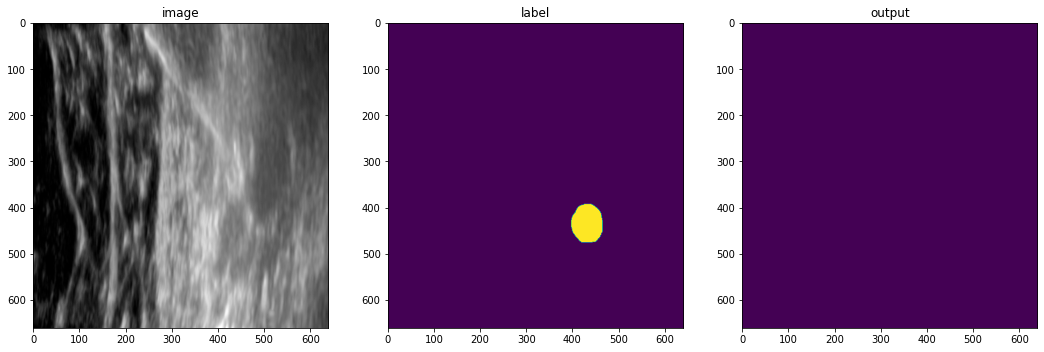

Loading dataset: 100%|██████████| 3/3 [00:07<00:00,  2.49s/it]

VFOLD = 6 of 9



Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


0
torch.Size([2, 3, 661, 640])
Average test dice score for Vfold 6 = 0.0
1
torch.Size([1, 3, 661, 640])
Average test dice score for Vfold 6 = 0.5048955678939819


Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


0
torch.Size([2, 3, 661, 640])
Average test dice score for Vfold 6 = 0.14808835089206696
1
torch.Size([1, 3, 661, 640])
Average test dice score for Vfold 6 = 0.15451078116893768


Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


0
torch.Size([2, 3, 661, 640])
Average test dice score for Vfold 6 = 0.07254308462142944
1
torch.Size([1, 3, 661, 640])
Average test dice score for Vfold 6 = 0.3062259256839752


Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


0
torch.Size([2, 3, 661, 640])
Average test dice score for Vfold 6 = 0.10284464806318283
1
torch.Size([1, 3, 661, 640])
Average test dice score for Vfold 6 = 0.5688615441322327


Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


0
torch.Size([2, 3, 661, 640])
Average test dice score for Vfold 6 = 0.07439706474542618
1
torch.Size([1, 3, 661, 640])
Average test dice score for Vfold 6 = 0.4672541916370392
total data length = 5
../../Data_PNB/annotations_yuri/1. 205 AC_Video 1_cropM.nii.gz
../../Data_PNB/annotations_yuri/3. 205 AC_Video 2_cropM.nii.gz
../../Data_PNB/annotations_yuri/4. 211 AC_Video 3_cropM.nii.gz
J = 0
Filename: 


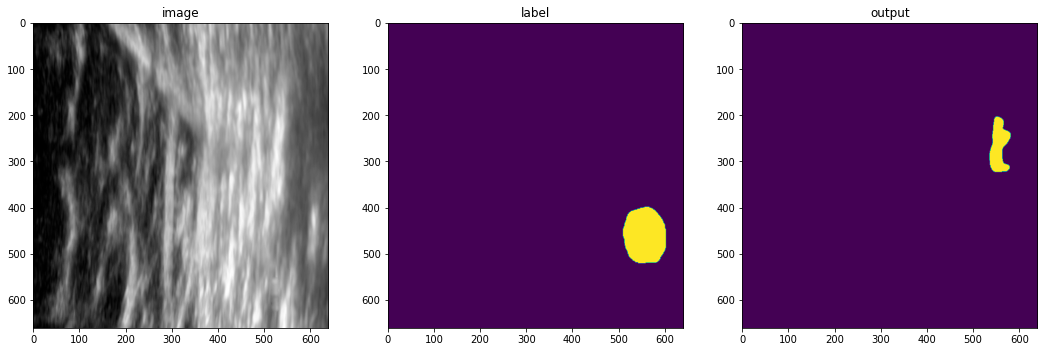

J = 1
Filename: 


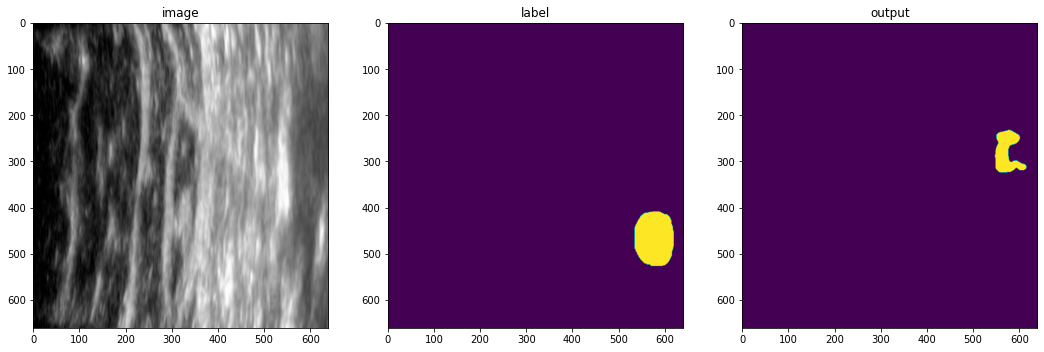

J = 2
Filename: 


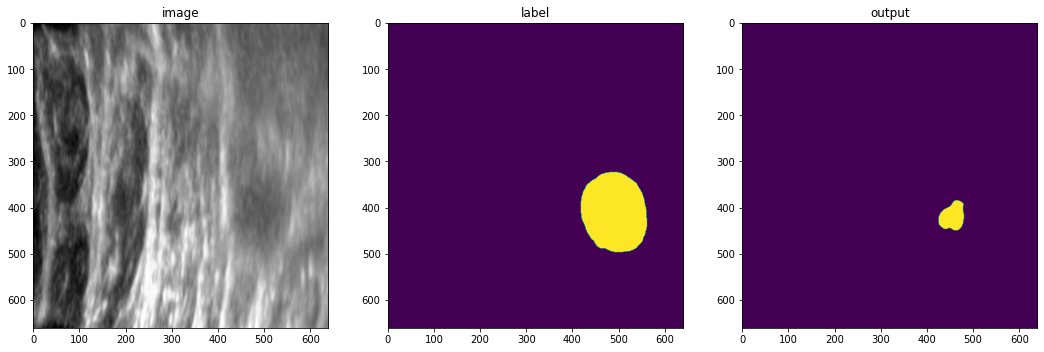

Loading dataset: 100%|██████████| 3/3 [00:03<00:00,  1.32s/it]

VFOLD = 7 of 9



Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


0
torch.Size([2, 3, 661, 640])
Average test dice score for Vfold 7 = 0.47380369901657104
1
torch.Size([1, 3, 661, 640])
Average test dice score for Vfold 7 = 0.3673972189426422


Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


0
torch.Size([2, 3, 661, 640])
Average test dice score for Vfold 7 = 0.7051051259040833
1
torch.Size([1, 3, 661, 640])
Average test dice score for Vfold 7 = 0.6263377070426941


Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


0
torch.Size([2, 3, 661, 640])
Average test dice score for Vfold 7 = 0.5367996692657471
1
torch.Size([1, 3, 661, 640])
Average test dice score for Vfold 7 = 0.6118869185447693


Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


0
torch.Size([2, 3, 661, 640])
Average test dice score for Vfold 7 = 0.6454131603240967
1
torch.Size([1, 3, 661, 640])
Average test dice score for Vfold 7 = 0.4823732376098633


Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


0
torch.Size([2, 3, 661, 640])
Average test dice score for Vfold 7 = 0.6808212399482727
1
torch.Size([1, 3, 661, 640])
Average test dice score for Vfold 7 = 0.30136656761169434
total data length = 5
../../Data_PNB/annotations_yuri/1. 217 AC_Video 1_cropM.nii.gz
../../Data_PNB/annotations_yuri/3. 217 AC_Video 2_cropM.nii.gz
../../Data_PNB/annotations_yuri/4. 222A_Video 2_cropM.nii.gz
J = 0
Filename: 


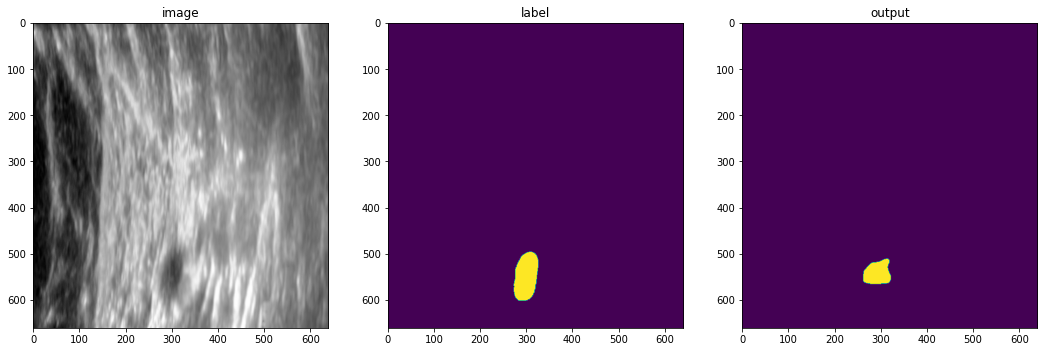

J = 1
Filename: 


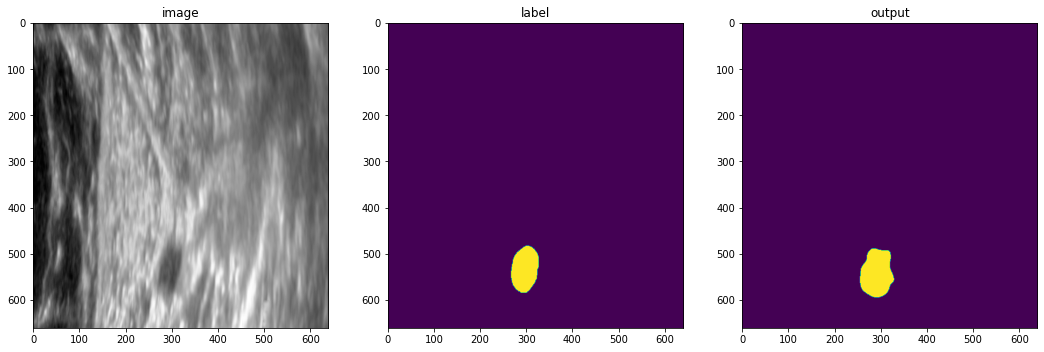

J = 2
Filename: 


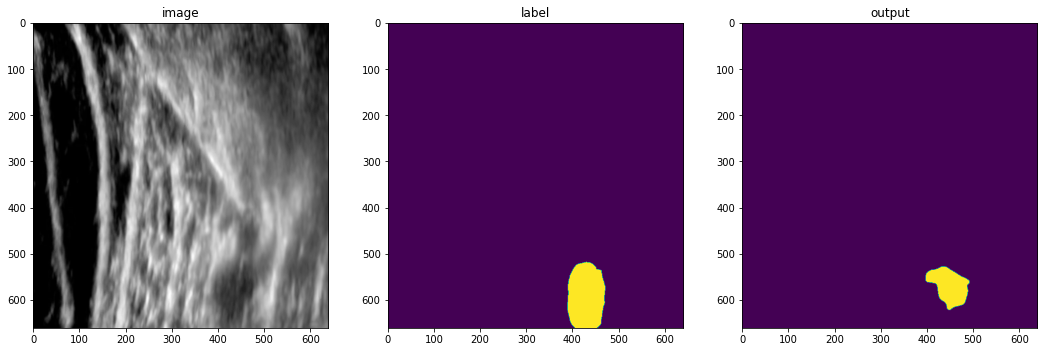

Loading dataset: 100%|██████████| 3/3 [00:06<00:00,  2.14s/it]

VFOLD = 8 of 9



Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


0
torch.Size([2, 3, 661, 640])
Average test dice score for Vfold 8 = 0.5265787839889526
1
torch.Size([1, 3, 661, 640])
Average test dice score for Vfold 8 = 0.4338066279888153


Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


0
torch.Size([2, 3, 661, 640])
Average test dice score for Vfold 8 = 0.688259482383728
1
torch.Size([1, 3, 661, 640])
Average test dice score for Vfold 8 = 0.477312296628952


Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


0
torch.Size([2, 3, 661, 640])
Average test dice score for Vfold 8 = 0.3319876790046692
1
torch.Size([1, 3, 661, 640])
Average test dice score for Vfold 8 = 0.3761247992515564


Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


0
torch.Size([2, 3, 661, 640])
Average test dice score for Vfold 8 = 0.5853732228279114
1
torch.Size([1, 3, 661, 640])
Average test dice score for Vfold 8 = 0.5566911101341248


Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


0
torch.Size([2, 3, 661, 640])
Average test dice score for Vfold 8 = 0.5631913542747498
1
torch.Size([1, 3, 661, 640])
Average test dice score for Vfold 8 = 0.7219684720039368
total data length = 5
../../Data_PNB/annotations_yuri/1. 238 AC_Video 1_cropM.nii.gz
../../Data_PNB/annotations_yuri/3. 238 AC_Video 2_cropM.nii.gz
../../Data_PNB/annotations_yuri/5. 153 AC_Video 3_cropM.nii.gz
J = 0
Filename: 


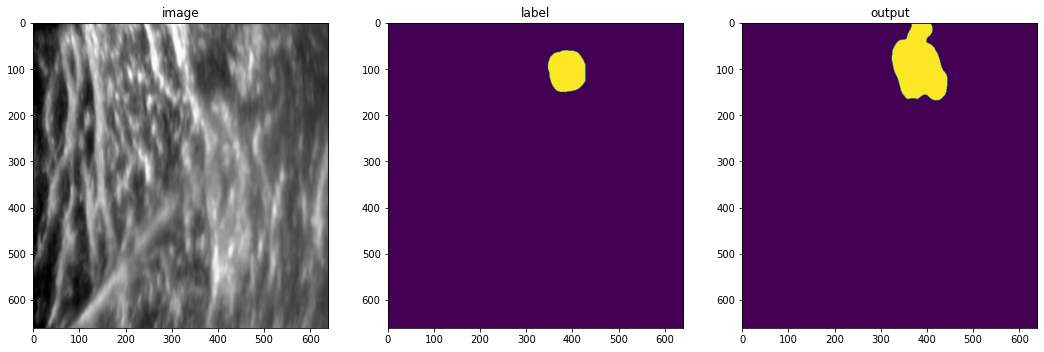

J = 1
Filename: 


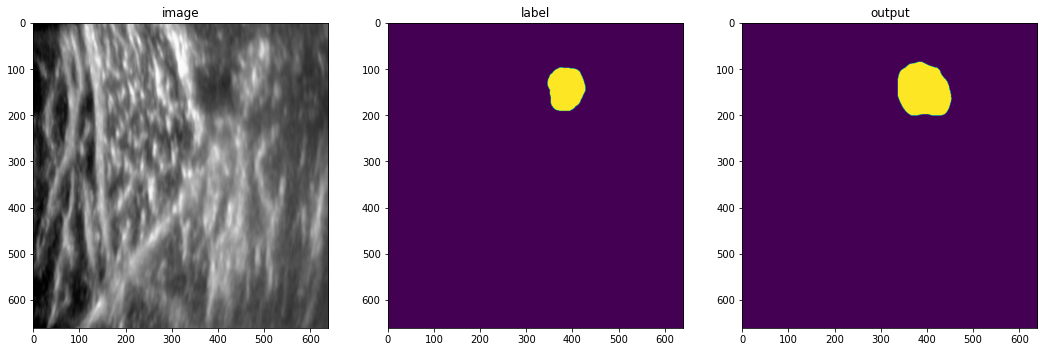

J = 2
Filename: 


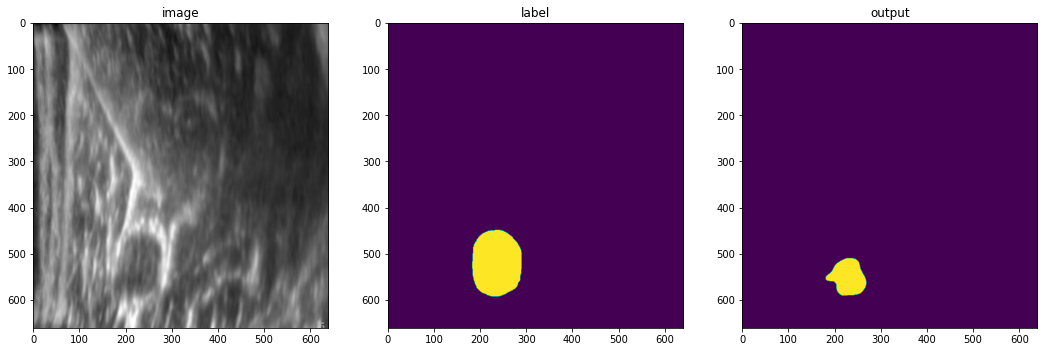

Loading dataset: 100%|██████████| 2/2 [00:09<00:00,  4.79s/it]

VFOLD = 9 of 9



Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


0
torch.Size([2, 3, 661, 640])
Average test dice score for Vfold 9 = 0.0


Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


0
torch.Size([2, 3, 661, 640])
Average test dice score for Vfold 9 = 0.00550402607768774


Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


0
torch.Size([2, 3, 661, 640])
Average test dice score for Vfold 9 = 0.0


Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


0
torch.Size([2, 3, 661, 640])
Average test dice score for Vfold 9 = 0.0


Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


0
torch.Size([2, 3, 661, 640])
Average test dice score for Vfold 9 = 0.0
total data length = 5
../../Data_PNB/annotations_yuri/2. 39 AC_Video 2_cropM.nii.gz
../../Data_PNB/annotations_yuri/5. 240 AC_Video 3_cropM.nii.gz
J = 0
Filename: 


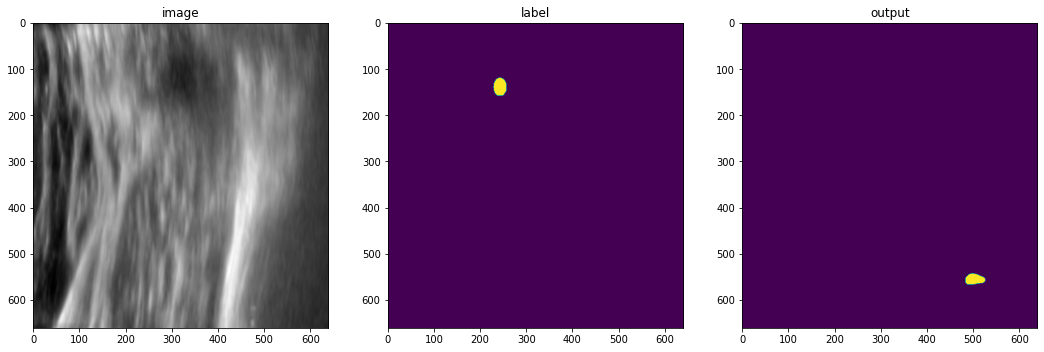

J = 1
Filename: 


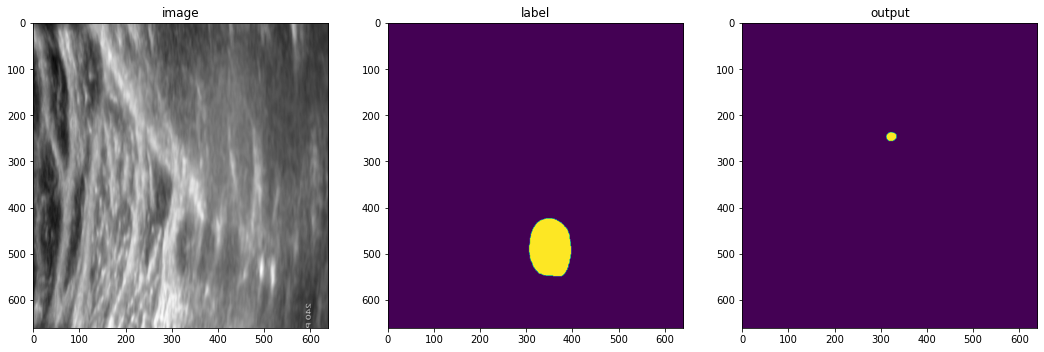

In [11]:
for i in range(0,num_folds,num_devices):
    test_ds = CacheDataset(data=test_files[i], transform=test_transforms,cache_rate=1.0, num_workers=num_workers_te)
    test_loader = DataLoader(test_ds, batch_size=batch_size_te, num_workers=num_workers_te)
    plot_vfold_training_curves(i,test_loader)
    test_loader.dataset._cache.clear()


In [1]:
import ipyparams
currentNotebook = "EnsembleClassPriorsTest-3D-PNB_CLEANED-Mean_StdOverTime_RawFrame-320x640.ipynb"
exp = "EnsembleClassPriorsTest-3D-PNB_CLEANED-Mean_StdOverTime_RawFrame-320x640-16s"

from datetime import datetime
now = datetime.now()
print(str(currentNotebook))
experimentName = exp+now.strftime("-%Y.%m.%d_%H.%M")
print(experimentName)
cmd = "jupyter nbconvert "+currentNotebook+" --output "+experimentName+" --to pdf"
import subprocess
subprocess.call(cmd, shell=True)

<IPython.core.display.Javascript object>

EnsembleClassPriorsTest-3D-PNB_CLEANED-Mean_StdOverTime_RawFrame-320x640.ipynb
EnsembleClassPriorsTest-3D-PNB_CLEANED-Mean_StdOverTime_RawFrame-320x640-16s-2022.07.05_10.43


[NbConvertApp] Converting notebook EnsembleClassPriorsTest-3D-PNB_CLEANED-Mean_StdOverTime_RawFrame-320x640.ipynb to pdf
[NbConvertApp] Support files will be in EnsembleClassPriorsTest-3D-PNB_CLEANED-Mean_StdOverTime_RawFrame-320x640-16s-2022.07.05_10.43_files/
[NbConvertApp] Making directory ./EnsembleClassPriorsTest-3D-PNB_CLEANED-Mean_StdOverTime_RawFrame-320x640-16s-2022.07.05_10.43_files
[NbConvertApp] Making directory ./EnsembleClassPriorsTest-3D-PNB_CLEANED-Mean_StdOverTime_RawFrame-320x640-16s-2022.07.05_10.43_files
[NbConvertApp] Making directory ./EnsembleClassPriorsTest-3D-PNB_CLEANED-Mean_StdOverTime_RawFrame-320x640-16s-2022.07.05_10.43_files
[NbConvertApp] Making directory ./EnsembleClassPriorsTest-3D-PNB_CLEANED-Mean_StdOverTime_RawFrame-320x640-16s-2022.07.05_10.43_files
[NbConvertApp] Making directory ./EnsembleClassPriorsTest-3D-PNB_CLEANED-Mean_StdOverTime_RawFrame-320x640-16s-2022.07.05_10.43_files
[NbConvertApp] Making directory ./EnsembleClassPriorsTest-3D-PNB_CLE

0